In [3]:
from math import sqrt

import os
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import shap
import plotly.express as px

# For shap to work with keras, disable v2 behavior
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
loc = './stats/'
MODEL_DIR = './models/'

In [5]:
X = pd.read_csv(loc + 'X.csv')
y = pd.read_csv(loc + 'y.csv')

# y = y[['PLAYER_PPG', 'PLAYER_APG', 'PLAYER_3PG']]
y = y['PLAYER_PTS']

# Baseline Models

## Baseline Model

A basic model that predicts the offensive player's points per 100 possessions will be their average points per 100 possessions

In [6]:
X_base = X.copy()
y_base = y.copy()

# X_base['OFF_3PM'] = X_base['OFF_FG3A'] * X_base['OFF_FG3_PCT']
# y_pred = X_base[['OFF_PTS', 'OFF_AST', 'OFF_3PM']].to_numpy()
y_pred = X_base['OFF_PTS_PER_100'].to_numpy()
y_base = y_base.to_numpy()

brmse = np.sqrt(np.mean((y_pred - y_base) ** 2))
bmae = mean_absolute_error(y_base, y_pred)
print('RMSE:', brmse)
print('MAE:', bmae)

RMSE: 13.090375678514178
MAE: 10.210982312288108


## Average Model

Takes the average of all players, and guesses that any one player's points is equal to that value

In [7]:
X_base = X.copy()
y_base = y.copy()

X_base = X_base['OFF_PTS_PER_100'].to_numpy()
y_base = y_base.to_numpy()

y_pred = [np.average(X_base)] * X_base.size

armse = np.sqrt(np.mean((y_pred - y_base) ** 2))
amae = mean_absolute_error(y_base, y_pred)
print('RMSE:', armse)
print('MAE:', amae)

RMSE: 11.591448250063664
MAE: 9.098261166422894


## Linear Regression Model

In [8]:
X.columns

Index(['DEF_AGE', 'DEF_GP', 'DEF_D_FGA', 'DEF_D_FG_PCT', 'DEF_NORMAL_FG_PCT',
       'DEF_W', 'DEF_L', 'DEF_MIN', 'DEF_STL', 'DEF_BLK', 'DEF_DREB',
       'DEF_CONTESTED_SHOTS', 'DEF_CONTESTED_SHOTS_3PT', 'DEF_CHARGES_DRAWN',
       'DEF_BOXOUTS', 'DEF_PCT_BOX_OUTS_REB', 'SEASON_ID', 'DEF_RATING',
       'DEF_DREB_PCT', 'DEF_PCT_STL', 'DEF_PCT_BLK', 'DEF_DEF_WS',
       'DEF_PLAYER_HEIGHT_INCHES', 'DEF_PLAYER_WEIGHT', 'OFF_AGE', 'OFF_GP',
       'OFF_MIN', 'OFF_FGA', 'OFF_FG_PCT', 'OFF_FG3A', 'OFF_FG3_PCT',
       'OFF_FTA', 'OFF_FT_PCT', 'OFF_REB', 'OFF_AST', 'OFF_TOV', 'OFF_BLKA',
       'OFF_PF', 'OFF_PAINT_TOUCHES', 'OFF_DRIVE_PTS', 'OFF_DRIVE_FG_PCT',
       'OFF_CATCH_SHOOT_PTS', 'OFF_CATCH_SHOOT_FG_PCT', 'OFF_PULL_UP_PTS',
       'OFF_PULL_UP_FG_PCT', 'OFF_PAINT_TOUCH_FG_PCT', 'OFF_POST_TOUCH_PTS',
       'OFF_POST_TOUCH_FG_PCT', 'OFF_ELBOW_TOUCH_PTS',
       'OFF_ELBOW_TOUCH_FG_PCT', 'OFF_PTS_PER_100', 'OFF_PLAYER_HEIGHT_INCHES',
       'OFF_PLAYER_WEIGHT'],
      dtype='object

In [9]:
from sklearn.linear_model import LinearRegression

X_base = X.copy()
X_base = X_base[['DEF_CONTESTED_SHOTS', 'DEF_D_FG_PCT', 'DEF_PCT_BLK', 'DEF_PCT_STL', 'OFF_AST', 'OFF_BLKA', 'OFF_FG_PCT', 'OFF_FG3_PCT', 'OFF_FT_PCT', 'OFF_TOV']]
y_base = y.copy()

X_base = X_base.to_numpy()
y_base = y_base.to_numpy()

model = LinearRegression().fit(X=X_base, y=y_base)
y_pred = model.predict(X_base)

lrmse = np.sqrt(np.mean((y_pred - y_base) ** 2))
lmae = mean_absolute_error(y_pred, y_base)

print('RMSE:', lrmse)
print('MAE:', lmae)

RMSE: 11.558738620034056
MAE: 9.020318349114314


In [10]:
from sklearn.linear_model import LinearRegression

X_base = X.copy()
X_base.drop(columns=['OFF_POST_TOUCH_PTS', 'OFF_POST_TOUCH_FG_PCT', 'OFF_PTS_PER_100'], inplace=True)
y_base = y.copy()

X_base = X_base.to_numpy()
y_base = y_base.to_numpy()

model = LinearRegression().fit(X=X_base, y=y_base)
y_pred = model.predict(X_base)

lrmse = np.sqrt(np.mean((y_pred - y_base) ** 2))
lmae = mean_absolute_error(y_pred, y_base)

print('RMSE:', lrmse)
print('MAE:', lmae)

RMSE: 11.328022617943873
MAE: 8.830999472912305


# Sequential Model

Creates a simple Keras model composed of single stack layers connected sequentially.

In [11]:
# Apply normalization to input
X = pd.read_csv(loc + 'X.csv')
X = (X - X.mean()) / X.std()

# Remove points from input dataset
try:
    X.drop(columns=['OFF_POST_TOUCH_PTS', 'OFF_POST_TOUCH_FG_PCT', 'OFF_PTS_PER_100'], inplace=True)
except:
    print('Already dropped')
# X = X[['OFF_MIN', 'OFF_FGA', 'DEF_BLK', 'DEF_D_FG_PCT', 'OFF_PLAYER_HEIGHT_INCHES', 'DEF_PLAYER_HEIGHT_INCHES']]

# Sort columns alphabetically
X = X.sort_index(axis=1)

# Generate training and verification data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Training Entries')
X_train.info()
X_train.describe()

print('Testing Entries')
X_test.info()
X_test.describe()

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X.columns

Training Entries
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13668 entries, 236 to 11456
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DEF_AGE                   13668 non-null  float64
 1   DEF_BLK                   13668 non-null  float64
 2   DEF_BOXOUTS               13668 non-null  float64
 3   DEF_CHARGES_DRAWN         13668 non-null  float64
 4   DEF_CONTESTED_SHOTS       13668 non-null  float64
 5   DEF_CONTESTED_SHOTS_3PT   13668 non-null  float64
 6   DEF_DEF_WS                13668 non-null  float64
 7   DEF_DREB                  13668 non-null  float64
 8   DEF_DREB_PCT              13668 non-null  float64
 9   DEF_D_FGA                 13668 non-null  float64
 10  DEF_D_FG_PCT              13668 non-null  float64
 11  DEF_GP                    13668 non-null  float64
 12  DEF_L                     13668 non-null  float64
 13  DEF_MIN                   13668 non-null  

Index(['DEF_AGE', 'DEF_BLK', 'DEF_BOXOUTS', 'DEF_CHARGES_DRAWN',
       'DEF_CONTESTED_SHOTS', 'DEF_CONTESTED_SHOTS_3PT', 'DEF_DEF_WS',
       'DEF_DREB', 'DEF_DREB_PCT', 'DEF_D_FGA', 'DEF_D_FG_PCT', 'DEF_GP',
       'DEF_L', 'DEF_MIN', 'DEF_NORMAL_FG_PCT', 'DEF_PCT_BLK',
       'DEF_PCT_BOX_OUTS_REB', 'DEF_PCT_STL', 'DEF_PLAYER_HEIGHT_INCHES',
       'DEF_PLAYER_WEIGHT', 'DEF_RATING', 'DEF_STL', 'DEF_W', 'OFF_AGE',
       'OFF_AST', 'OFF_BLKA', 'OFF_CATCH_SHOOT_FG_PCT', 'OFF_CATCH_SHOOT_PTS',
       'OFF_DRIVE_FG_PCT', 'OFF_DRIVE_PTS', 'OFF_ELBOW_TOUCH_FG_PCT',
       'OFF_ELBOW_TOUCH_PTS', 'OFF_FG3A', 'OFF_FG3_PCT', 'OFF_FGA',
       'OFF_FG_PCT', 'OFF_FTA', 'OFF_FT_PCT', 'OFF_GP', 'OFF_MIN',
       'OFF_PAINT_TOUCHES', 'OFF_PAINT_TOUCH_FG_PCT', 'OFF_PF',
       'OFF_PLAYER_HEIGHT_INCHES', 'OFF_PLAYER_WEIGHT', 'OFF_PULL_UP_FG_PCT',
       'OFF_PULL_UP_PTS', 'OFF_REB', 'OFF_TOV', 'SEASON_ID'],
      dtype='object')

In [12]:
outsize = 0
try:
    outsize = y.shape[1]
except:
    outsize = 1

# Create model
model = Sequential()
model.add(Dense(int(X.shape[1] * 2), activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(outsize, activation='relu'))

# Compile model
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mse', 'mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,629
Trainable params: 11,629
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Set batch size
bsize = int(X_train.shape[0] * 0.6)

# Fit model
%time history = model.fit(X_train, y_train, epochs=2000, validation_split=0.2, batch_size=bsize, verbose=0)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Wall time: 56.7 s


In [14]:
y_pred = model.predict(X_test)

# Evaluate error
score, mse, mae = model.evaluate(X_test, y_test)
rmse = sqrt(mse)

print('RMSE:', rmse)
print('MAE:', mae)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


RMSE: 11.624912712835942
MAE: 8.991289


In [15]:
# Plot training and validation loss
fig = px.line()
fig.add_scatter(y=history.history['loss'], name='Train')
fig.add_scatter(y=history.history['val_loss'], name='Validation')

fig.update_layout(title='Train vs Validation Loss',
                   xaxis_title='Epochs',
                   yaxis_title='Loss')

fig.show()

Predicted vs Actual Distributions

In [16]:
# Predicted distribution
fig = px.histogram(y_pred, nbins=70)
fig.show()
print(np.std(y_pred))

# Actual distribution
fig = px.histogram(y_test)
fig.show()
print(np.std(y_test))

3.369942


11.667496614431146


Total RMSE and MAE

In [17]:
score, mse, mae = model.evaluate(X, y)
rmse = sqrt(mse)
print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 11.034419223174975
MAE: 8.533056


In [18]:
print('RMSE improvement over Baseline(%):', (brmse - rmse)/brmse * 100)
print('MAE improvement over Baseline(%):', (bmae - mae)/bmae * 100)
print('RMSE improvement over Average(%):', (armse - rmse)/armse * 100)
print('MAE improvement over Average(%):', (amae - mae)/amae * 100)
print('RMSE improvement over Linear Regression(%):', (lrmse - rmse)/lrmse * 100)
print('MAE improvement over Linear Regression(%):', (lmae - mae)/lmae * 100)

RMSE improvement over Baseline(%): 15.705862886072373
MAE improvement over Baseline(%): 16.43256252744247
RMSE improvement over Average(%): 4.805517092185864
MAE improvement over Average(%): 6.21222997371748
RMSE improvement over Linear Regression(%): 2.5918327025920873
MAE improvement over Linear Regression(%): 3.3738334451375


In [19]:
# compute SHAP values
explainer = shap.DeepExplainer(model, X_train[0:1000])
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X.columns)

c:\Users\Darrick\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:91: UserWarning:

keras is no longer supported, please use tf.keras instead.

c:\Users\Darrick\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



PLAYER_PTS


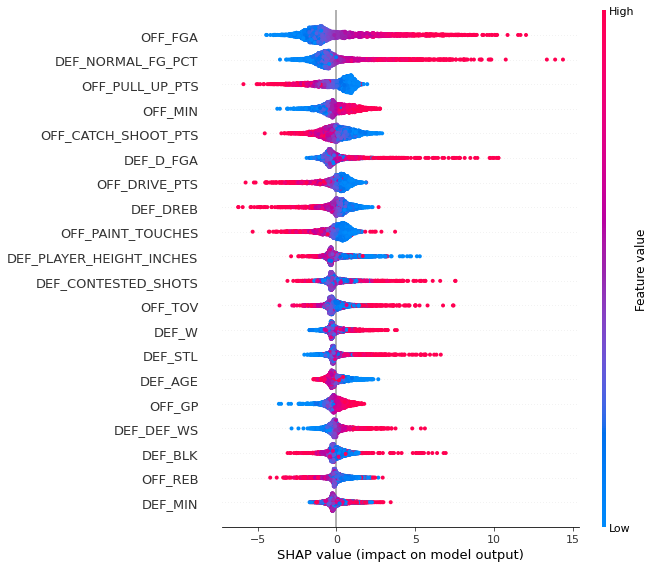

In [20]:
for i in range(0, outsize):
    try:
        print(y.columns[i])
    except:
        print(y.name)
    shap.summary_plot(shap_values[i], X_test, feature_names=X.columns)

In [21]:
import tensorflowjs as tfjs

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

name = input('Set model name: ')
model.save(MODEL_DIR + name + '_keras')
tfjs.converters.save_keras_model(model, MODEL_DIR + name + '_js')